# Add representations to DB
For every experiment, add representations to a separate table.
We use the following representations:
- SMILES of product A (expected product)
- SMILES of reactants I, M, T
- reactionsSMILES
- atom-mapped, unbalanced reactionSMILES

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../..'))

from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import (
    Draw,
    rdChemReactions,
)

from src.util.db_utils import SynFermDatabaseConnection
from src.util.rdkit_util import map_reactions, desalt_building_block

In [2]:
# connect to DB
con = SynFermDatabaseConnection()

In [3]:
# import experiments
res = con.con.execute("SELECT e.id, e.initiator_long, e.monomer_long, e.terminator_long, e.product_A_smiles, bb1.SMILES, bb2.SMILES, bb3.SMILES FROM experiments as e LEFT JOIN building_blocks as bb1 on e.initiator_long = bb1.long LEFT JOIN building_blocks as bb2 on e.monomer_long = bb2.long LEFT JOIN building_blocks as bb3 on e.terminator_long = bb3.long;").fetchall()

columns = ['experiment_id', 'initiator_long', 'monomer_long', 'terminator_long', 'product_A_smiles', 'initiator_smiles', 'monomer_smiles', 'terminator_smiles']


In [4]:
def make_reaction_smiles(initiator, monomer, terminator, product):
    """Form unmapped, plain reactionSMILES"""
    return f"{initiator}.{monomer}.{terminator}>>{product}"

In [5]:
reaction_smiles = [make_reaction_smiles(*(exp[5:] + exp[4:5])) for exp in res]
len(reaction_smiles)

58664

In [6]:
rxn_TH = rdChemReactions.ReactionFromSmarts(
        '[#9]-[#5-](-[#9])(-[#9])-[#6:2](-[*:1])=[#8:3].[#8]=[#6]-1-[#8]-C-2(-[#6]-[#6]-[#6]-[#6]-[#6]2)-[#8]-[#6:7]11-[#6:6]-[#6:5]-[#7:4]-[#8]-1.[#6:11]-[#6:10](=[#16:12])-[#7:9]-[#7:8]>>[#6:11]-[#6:10]:1:[#7:9]:[#7:8]:[#6:7](-[#6:6]-[#6:5]-[#7:4]-[#6:2](-[*:1])=[#8:3]):[#16:12]-1'
    )

rxn_ABT = rdChemReactions.ReactionFromSmarts(
    "[#9]-[#5-](-[#9])(-[#9])-[#6:2](-[*:1])=[#8:3].[#8]=[#6]-1-[#8]-C-2(-[#6]-[#6]-[#6]-[#6]-[#6]2)-[#8]-[#6:7]11-[#6:6]-[#6:5]-[#7:4]-[#8]-1.[#7:8]-[#6:9]1:[#6:10]:[#6:11]:[#6:12]:[#6:13]:[#6:14]:1-[#16:15]>>[*:1]-[#6:2](=[#8:3])-[#7:4]-[#6:5]-[#6:6]-[#6:7]1:[#7:8]:[#6:9]2:[#6:10]:[#6:11]:[#6:12]:[#6:13]:[#6:14]:2:[#16:15]:1"
)
# prepare for visualization
rdChemReactions.Compute2DCoordsForReaction(rxn_TH)
rdChemReactions.Compute2DCoordsForReaction(rxn_ABT)
# prepare for enumeration
rxn_TH.Initialize()
rxn_ABT.Initialize()
# validate reactions
n_warn_TH, n_err_TH = rxn_TH.Validate(silent=True)
n_warn_ABT, n_err_ABT = rxn_ABT.Validate(silent=True)
if n_err_TH > 0:
    raise ValueError(f'Invalid reaction gave {n_err_TH} errors in validation')
if n_err_ABT > 0:
    raise ValueError(f'Invalid reaction gave {n_err_ABT} errors in validation')

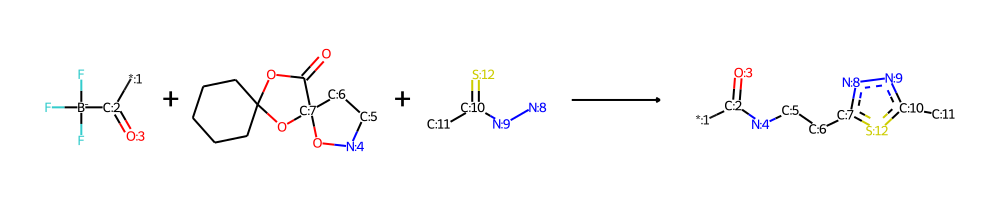

In [7]:
Draw.ReactionToImage(rxn_TH)

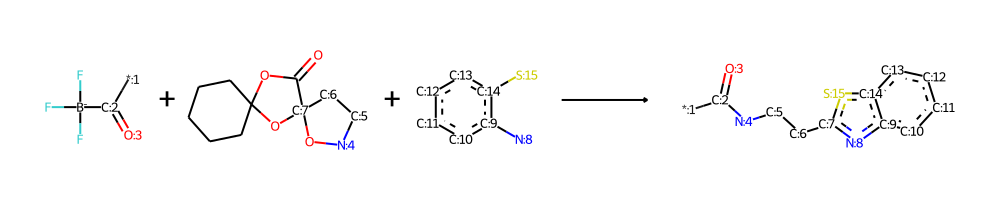

In [8]:
Draw.ReactionToImage(rxn_ABT)

In [15]:
rxn = map_reactions(rxn_TH, [[Chem.Mol(desalt_building_block(Chem.MolFromSmiles(smiles))) for smiles in reaction[5:]] for reaction in res[0:3]])

ERROR: No product for reactant set with index 1


In [21]:
rxns_abt = map_reactions(rxn_ABT, [[Chem.Mol(desalt_building_block(Chem.MolFromSmiles(smiles))) for smiles in reaction[5:]] for reaction in res])

ERROR: No product for reactant set with index 0
ERROR: No product for reactant set with index 2


In [23]:
rxns_th = map_reactions(rxn_TH, [[Chem.Mol(desalt_building_block(Chem.MolFromSmiles(smiles))) for smiles in reaction[5:]] for reaction in res])

ERROR: No product for reactant set with index 1
ERROR: No product for reactant set with index 7
ERROR: No product for reactant set with index 8
ERROR: No product for reactant set with index 9
ERROR: No product for reactant set with index 11
ERROR: No product for reactant set with index 17
ERROR: No product for reactant set with index 18
ERROR: No product for reactant set with index 19
ERROR: No product for reactant set with index 21
ERROR: No product for reactant set with index 27
ERROR: No product for reactant set with index 28
ERROR: No product for reactant set with index 29
ERROR: No product for reactant set with index 31
ERROR: No product for reactant set with index 37
ERROR: No product for reactant set with index 38
ERROR: No product for reactant set with index 39
ERROR: No product for reactant set with index 41
ERROR: No product for reactant set with index 47
ERROR: No product for reactant set with index 48
ERROR: No product for reactant set with index 49
ERROR: No product for re

KeyboardInterrupt: 

In [11]:
mol = [Chem.Mol(desalt_building_block(Chem.MolFromSmiles(smiles))) for smiles in res[0][5:]]

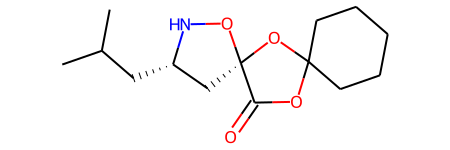

In [12]:
Chem.Mol(mol)

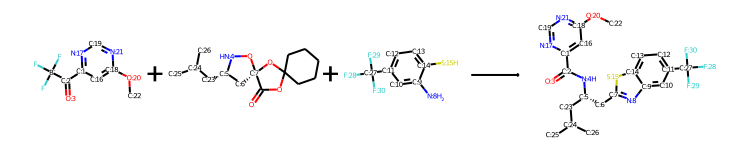

In [22]:
rxn[1][0]

In [ ]:
df["initiator_MOL"] = df["initiator_SMILES"].apply(MolFromSmiles)
df["monomer_MOL"] = df["monomer_SMILES"].apply(MolFromSmiles)
df["terminator_MOL"] = df["terminator_SMILES"].apply(MolFromSmiles)
reactants_TH = df.loc[df["terminator_type"] == "TerTH", ["initiator_MOL", "monomer_MOL", "terminator_MOL"]].values.tolist()
indices_TH = df.loc[df["terminator_type"] == "TerTH"].index